In [1]:
import pandas as pd # Data manipulation and analysis.
import numpy as np # Numerical operations and array handling.
import matplotlib.pyplot as plt # More control, lower-level, basic plotting.
import seaborn as sns # Higher-level, more aesthetically pleasing plots.
from scipy import stats # Statistical functions and tests.


pd.set_option('display.max_columns', None) # Display all columns in DataFrame output.
pd.set_option('display.max_rows', None) # Display all rows in DataFrame output.

### Load all CSV data

In [2]:
df = pd.read_csv('/Users/xiaowenrou/Downloads/COMP647/financial_fraud_detection_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 18 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   transaction_id               object 
 1   timestamp                    object 
 2   sender_account               object 
 3   receiver_account             object 
 4   amount                       float64
 5   transaction_type             object 
 6   merchant_category            object 
 7   location                     object 
 8   device_used                  object 
 9   is_fraud                     bool   
 10  fraud_type                   object 
 11  time_since_last_transaction  float64
 12  spending_deviation_score     float64
 13  velocity_score               int64  
 14  geo_anomaly_score            float64
 15  payment_channel              object 
 16  ip_address                   object 
 17  device_hash                  object 
dtypes: bool(1), float64(4), int64(1), object(1

### Remove irrelevant data

When building a fraud detection model, each feature must be available in real-time in real-world transaction processing scenarios and have the ability to distinguish between legitimate and fraudulent transactions.

- `transaction_id`: The transaction ID is a unique identifier generated by the system and does not contain any predictive information.
- `sender_account` & `receiver_account`: Account identifiers can lead to model overfitting: most transactions involve new account combinations that have never been seen before.
- `fraud_type`: We only need binary classification, not classification of fraud types, so remove this column.
- `ip_address`: IP addresses are dynamically allocated, so the same user may use different IP addresses, and different users may share the same IP address.

In [3]:
columns_to_remove = [
    'transaction_id',
    'sender_account',
    'receiver_account',
    'fraud_type',
    'ip_address'
]

df = df.drop(columns = columns_to_remove)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 13 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   timestamp                    object 
 1   amount                       float64
 2   transaction_type             object 
 3   merchant_category            object 
 4   location                     object 
 5   device_used                  object 
 6   is_fraud                     bool   
 7   time_since_last_transaction  float64
 8   spending_deviation_score     float64
 9   velocity_score               int64  
 10  geo_anomaly_score            float64
 11  payment_channel              object 
 12  device_hash                  object 
dtypes: bool(1), float64(4), int64(1), object(7)
memory usage: 462.5+ MB


### Remove Null value rows
In this section, we use different data checking strategies for different data types.

- For categorical variables (`transaction_type`, `merchant_category`, `location`, `device_used`, `payment_channel`, `device_hash`), a complete deletion strategy is adopted. When missing values ​​appear in these fields, the entire row of data containing the missing value is directly deleted. For the missing of such categorical variables, forced filling will introduce noise and may mislead model learning.

- For numeric variables (`amount`, `time_since_last_transaction`, `spending_deviation_score`, `velocity_score`, `geo_anomaly_score`), the fill method is used. `time_since_last_transaction`: Missing values ​​are filled with -1 to specifically identify first-time transaction users.

In [4]:
missing_values = df.isnull().sum()
print(missing_values)

rows_before = len(df)

# Handling categorical variables: remove the row if missing
categorical_cols = ['transaction_type', 'merchant_category', 'location', 'device_used', 'payment_channel', 'device_hash']
for col in categorical_cols:
    if col in df.columns and df[col].isnull().any():
        missing_count_before = df[col].isnull().sum()
        df = df.dropna(subset=[col])

# Handling numbric variables: 
numerical_cols = ['amount', 'time_since_last_transaction', 'spending_deviation_score', 'velocity_score', 'geo_anomaly_score']
for col in numerical_cols:
    if col in df.columns and df[col].isnull().any():
        if col == 'time_since_last_transaction':
            # For first-time transaction users, setting this to -1 means no transaction history
            df[col] = df[col].fillna(-1)
        else:
            # Other values ​​are filled with median
            df[col] = df[col].fillna(df[col].median())

rows_after = len(df)
print(f"{rows_before - rows_after} rows are removed from data set")
df.info()


timestamp                           0
amount                              0
transaction_type                    0
merchant_category                   0
location                            0
device_used                         0
is_fraud                            0
time_since_last_transaction    896513
spending_deviation_score            0
velocity_score                      0
geo_anomaly_score                   0
payment_channel                     0
device_hash                         0
dtype: int64
0 rows are removed from data set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 13 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   timestamp                    object 
 1   amount                       float64
 2   transaction_type             object 
 3   merchant_category            object 
 4   location                     object 
 5   device_used                  object 
 6   is_fra

### Remove Duplicates and Constant Features

- Duplicate value handling strategy: Use a complete deletion strategy, retaining the first record in each set of duplicate data. This approach is simple and direct, avoiding errors that may be introduced by complex duplicate data merging logic.
- Constant feature identification strategy: Each feature column is checked for the number of unique values ​​`nunique()`. If the number of unique values ​​is less than or equal to 1, the feature is considered a constant feature. All constant feature columns are deleted, but the target variable `is_fraud` is particularly protected. Even in extremely imbalanced datasets, the target variable should not be mistakenly deleted because it is the core basis for model learning.

In [5]:
duplicated_values = df.duplicated().sum()
print(f"Duplicated rows: {duplicated_values}")

# Remove duplicate rows if found
if duplicated_values > 0:
   df = df.drop_duplicates()
   print(f"{duplicated_values} duplicated rows are removed from data set")

# Remove Constant Features  
constant_features = []
for col in df.columns:
   if col != 'is_fraud':
       if df[col].nunique() <= 1:
           constant_features.append(col)

if constant_features:
   df = df.drop(columns=constant_features)
   print(f"{len(constant_features)} constant features are removed: {constant_features}")

df.info()

Duplicated rows: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 13 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   timestamp                    object 
 1   amount                       float64
 2   transaction_type             object 
 3   merchant_category            object 
 4   location                     object 
 5   device_used                  object 
 6   is_fraud                     bool   
 7   time_since_last_transaction  float64
 8   spending_deviation_score     float64
 9   velocity_score               int64  
 10  geo_anomaly_score            float64
 11  payment_channel              object 
 12  device_hash                  object 
dtypes: bool(1), float64(4), int64(1), object(7)
memory usage: 462.5+ MB


### Numerical Columns Analysis
Fraudulent transactions are often "abnormal." "Outliers" such as unusually high transaction amounts, unusual geographic locations, and unusual transaction frequencies can be important features for identifying fraud.
Therefore, the outlier handling strategy is to examine the outlier distributions of normal and fraudulent samples separately.

- `amount`: Identifies unusually large or small transactions
- `time_since_last_transaction`: Detects unusually frequent or rare transaction patterns
- `spending_deviation_score`: Captures anomalies that significantly deviate from a user's historical behavior
- `velocity_score`: Identifies unusual transaction velocity patterns
- `geo_anomaly_score`: Detects geographic anomalies

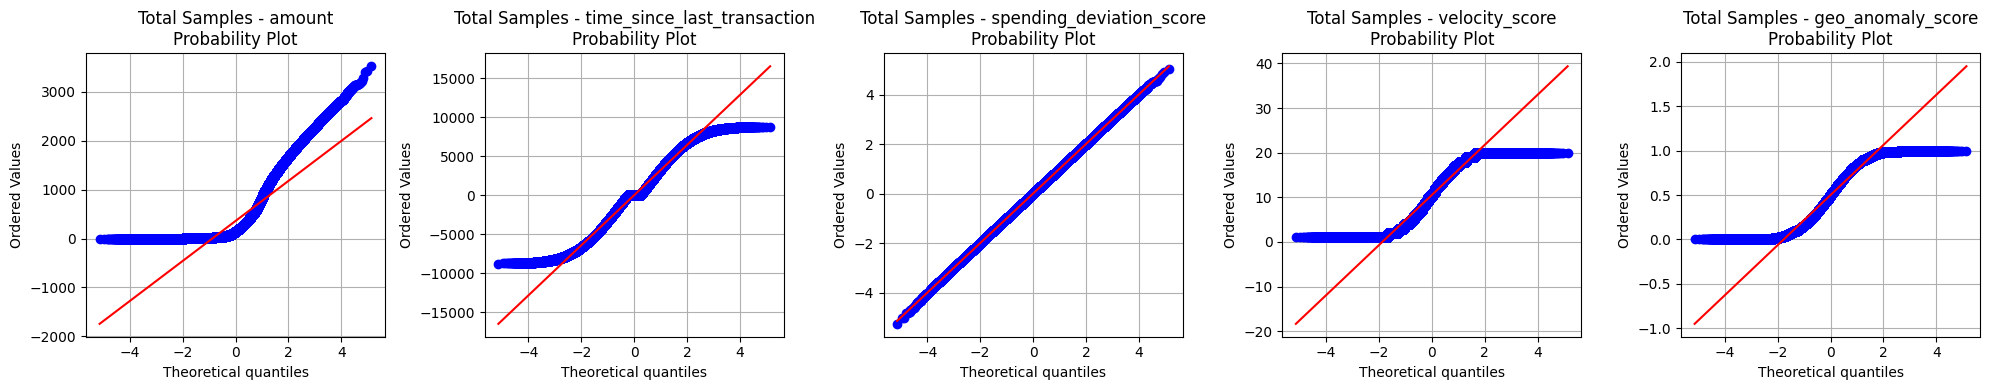

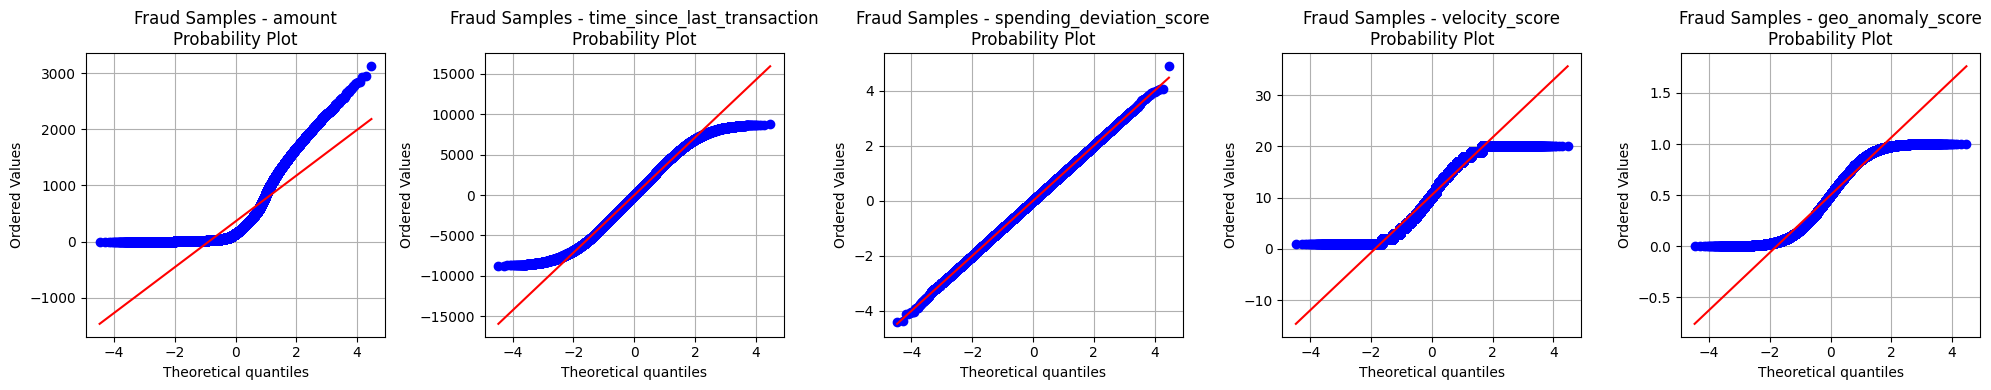

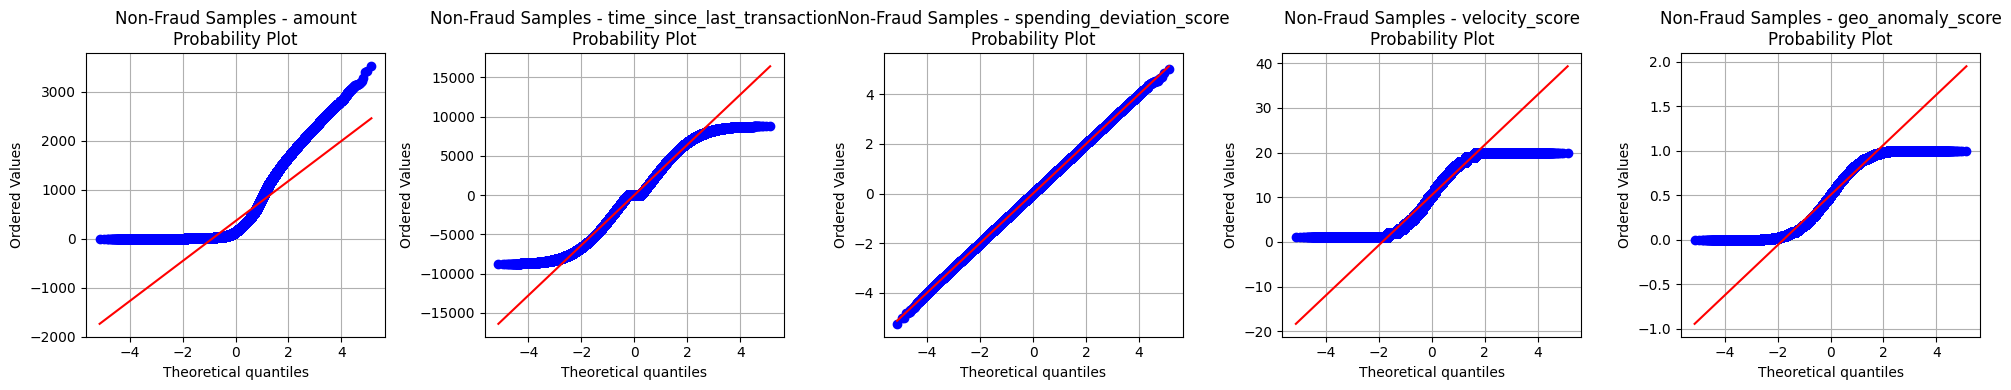

In [6]:
import warnings
warnings.filterwarnings('ignore')

df_before_outlier_removal = df.copy()

fraud_data = df[df['is_fraud'] == True]
non_fraud_data = df[df['is_fraud'] == False]


fig, axes = plt.subplots(1, len(numerical_cols), figsize=(20, 4))
for i, col in enumerate(numerical_cols):
    if col in df.columns:
        data = df[col].dropna()
        stats.probplot(data, dist="norm", plot=axes[i])
        axes[i].set_title(f'Total Samples - {col}\nProbability Plot')
        axes[i].grid(True)

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, len(numerical_cols), figsize=(20, 4))
for i, col in enumerate(numerical_cols):
    if col in df.columns:
        data = fraud_data[col].dropna()
        stats.probplot(data, dist="norm", plot=axes[i])
        axes[i].set_title(f'Fraud Samples - {col}\nProbability Plot')
        axes[i].grid(True)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, len(numerical_cols), figsize=(20, 4))
for i, col in enumerate(numerical_cols):
    if col in df.columns:
        data = non_fraud_data[col].dropna()
        stats.probplot(data, dist="norm", plot=axes[i])
        axes[i].set_title(f'Non-Fraud Samples - {col}\nProbability Plot')
        axes[i].grid(True)

plt.tight_layout()
plt.show()


A comparison reveals that the distribution of each feature is nearly identical in both normal and fraudulent samples.

- `amount`: Distribution clearly right-skewed, with extreme values.

- `time_since_last_transaction`: Distribution clearly right-skewed, with a significant clustering of extreme values.

- `spending_deviation_score`: Closest to a normal distribution, but with slight deviations at either end.

- `velocity_score`: Distribution clearly right-skewed, with a long tail.

- `Geo_anomaly_score`: Distribution relatively mildly right-skewed.

### Calculate fraud transaction rate
In fraud detection scenarios, normal transactions often far outnumber fraudulent transactions, resulting in a highly unbalanced data distribution. Fraud rate calculation can accurately quantify the degree of this imbalance.

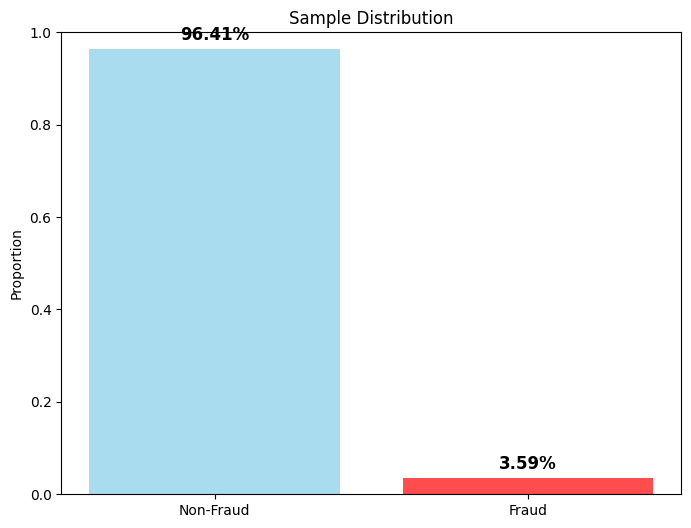

In [7]:
fraud_rate = df['is_fraud'].mean()
normal_rate = 1 - fraud_rate

categories = ['Non-Fraud', 'Fraud']
rates = [normal_rate, fraud_rate]

plt.figure(figsize=(8, 6))
bars = plt.bar(categories, rates, color=['skyblue', 'red'], alpha=0.7)
plt.ylabel('Proportion')
plt.title('Sample Distribution')
plt.ylim(0, 1)

for bar, rate in zip(bars, rates):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{rate:.2%}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

### Feature Creation

This step converts the original timestamp data into categorical features with clear business meaning. In financial fraud detection, the time dimension contains rich behavioral pattern information. Normal user transaction behavior usually follows predictable time patterns.

- `is_business_hours`: This period is usually the main window for normal business activities.
- `is_late_night`: Identify late-night trading between 10 PM and 6 AM, as this period of time is considered unusual.
- `month`: Identify the transaction month.
- `hour`: Identify the transaction hour.
- `is_weekend`: Distinguishing between weekday and weekend trading patterns.

In [8]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['hour'] = df['timestamp'].dt.hour
df['month'] = df['timestamp'].dt.month
df['is_business_hours'] = ((df['hour'] >= 9) & (df['hour'] <= 17)).astype(int)
df['is_late_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df["is_fraud"] = df["is_fraud"].astype(int)

# Remove helper columns
columns_to_remove = [
    'day_of_week',
]

df = df.drop(columns=columns_to_remove)

Divide the data into fraudulent and normal data, and then view their heatmaps separately.

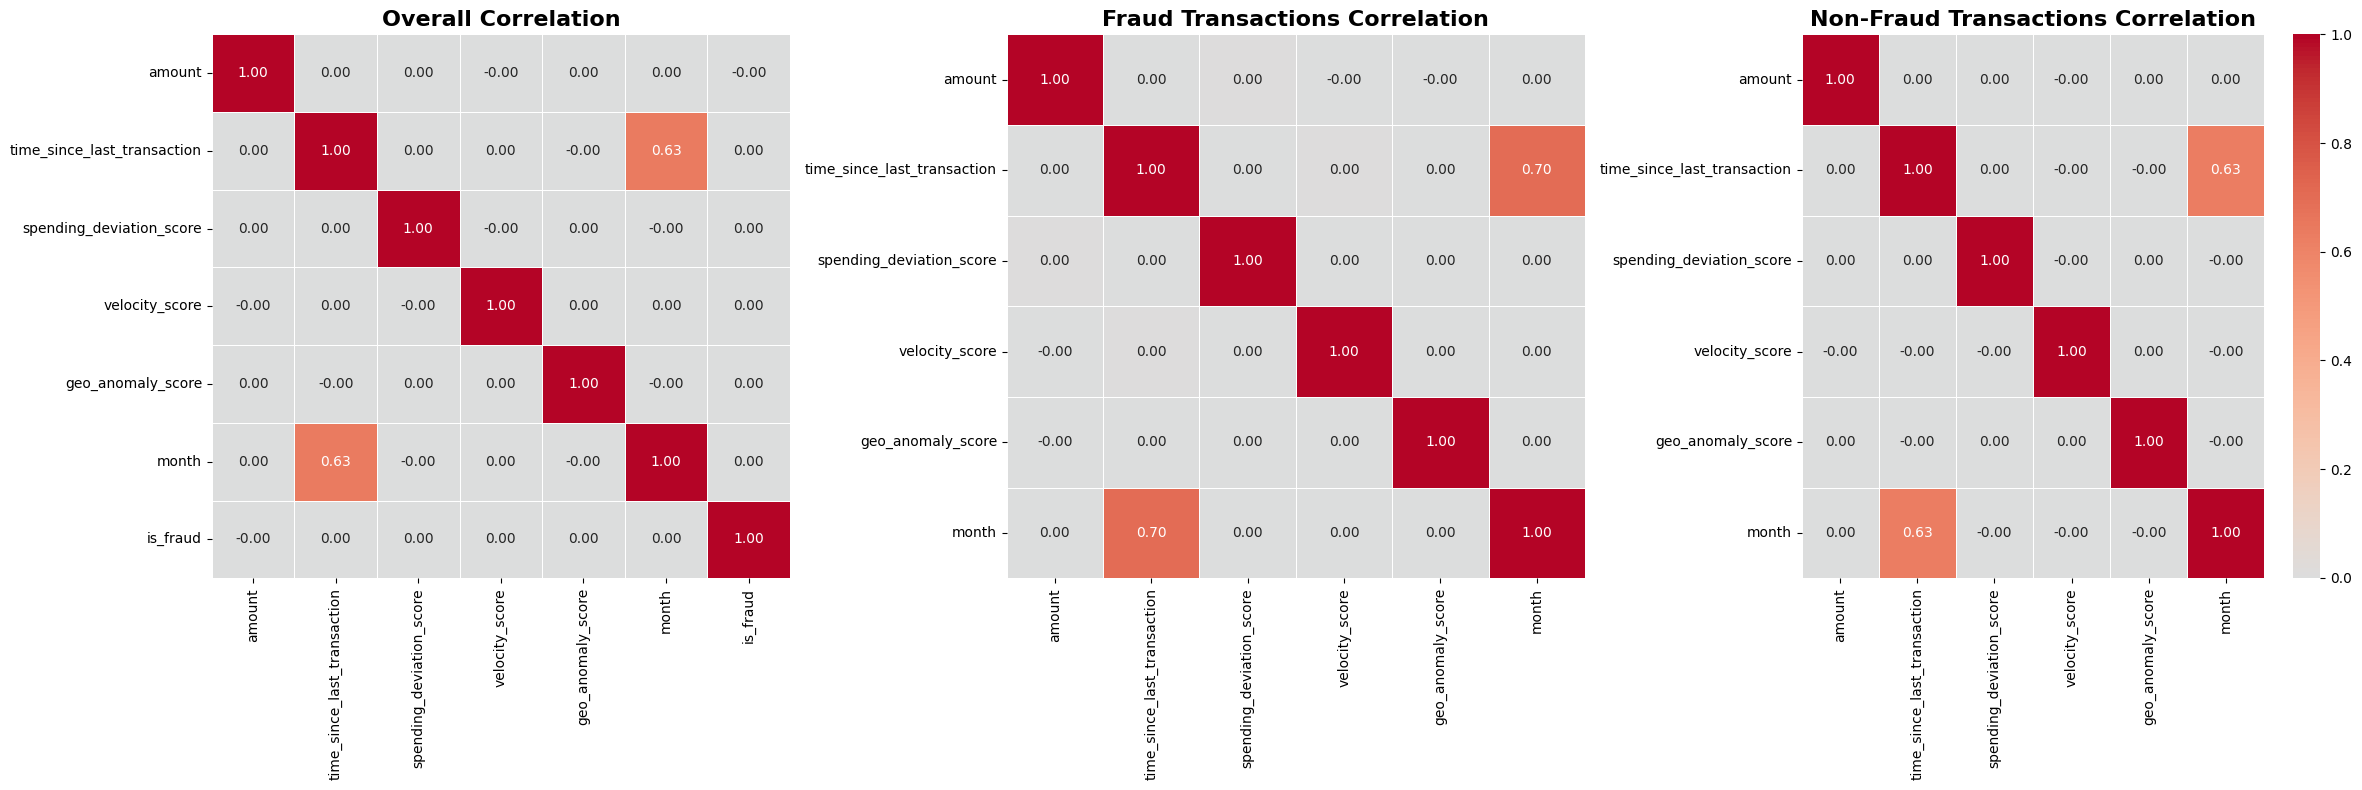

In [9]:
corr_df = df[["timestamp", "amount", "time_since_last_transaction", "spending_deviation_score", "velocity_score", "geo_anomaly_score", "month", "is_fraud"]]

numeric_cols = ["amount", "time_since_last_transaction", "spending_deviation_score", "velocity_score", "geo_anomaly_score", "month"]

fraud_data = corr_df[corr_df['is_fraud'] == 1][numeric_cols]
non_fraud_data = corr_df[corr_df['is_fraud'] == 0][numeric_cols]
overall_data = corr_df[numeric_cols + ['is_fraud']]

overall_correlation_matrix = overall_data.corr()
fraud_correlation_matrix = fraud_data.corr()
non_fraud_correlation_matrix = non_fraud_data.corr()

fig, axes = plt.subplots(1, 3, figsize=(24, 8))

sns.heatmap(overall_correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5, cbar=False, fmt='.2f', ax=axes[0])
axes[0].set_title(f"Overall Correlation", fontsize=16, fontweight='bold')

sns.heatmap(fraud_correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5, cbar=False, fmt='.2f', ax=axes[1])
axes[1].set_title(f"Fraud Transactions Correlation", fontsize=16, fontweight='bold')

sns.heatmap(non_fraud_correlation_matrix, annot=True, cmap='coolwarm', center=0,linewidths=0.5, cbar=True, fmt='.2f', ax=axes[2])
axes[2].set_title(f"Non-Fraud Transactions Correlation", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

### Categorical Columns Analysis




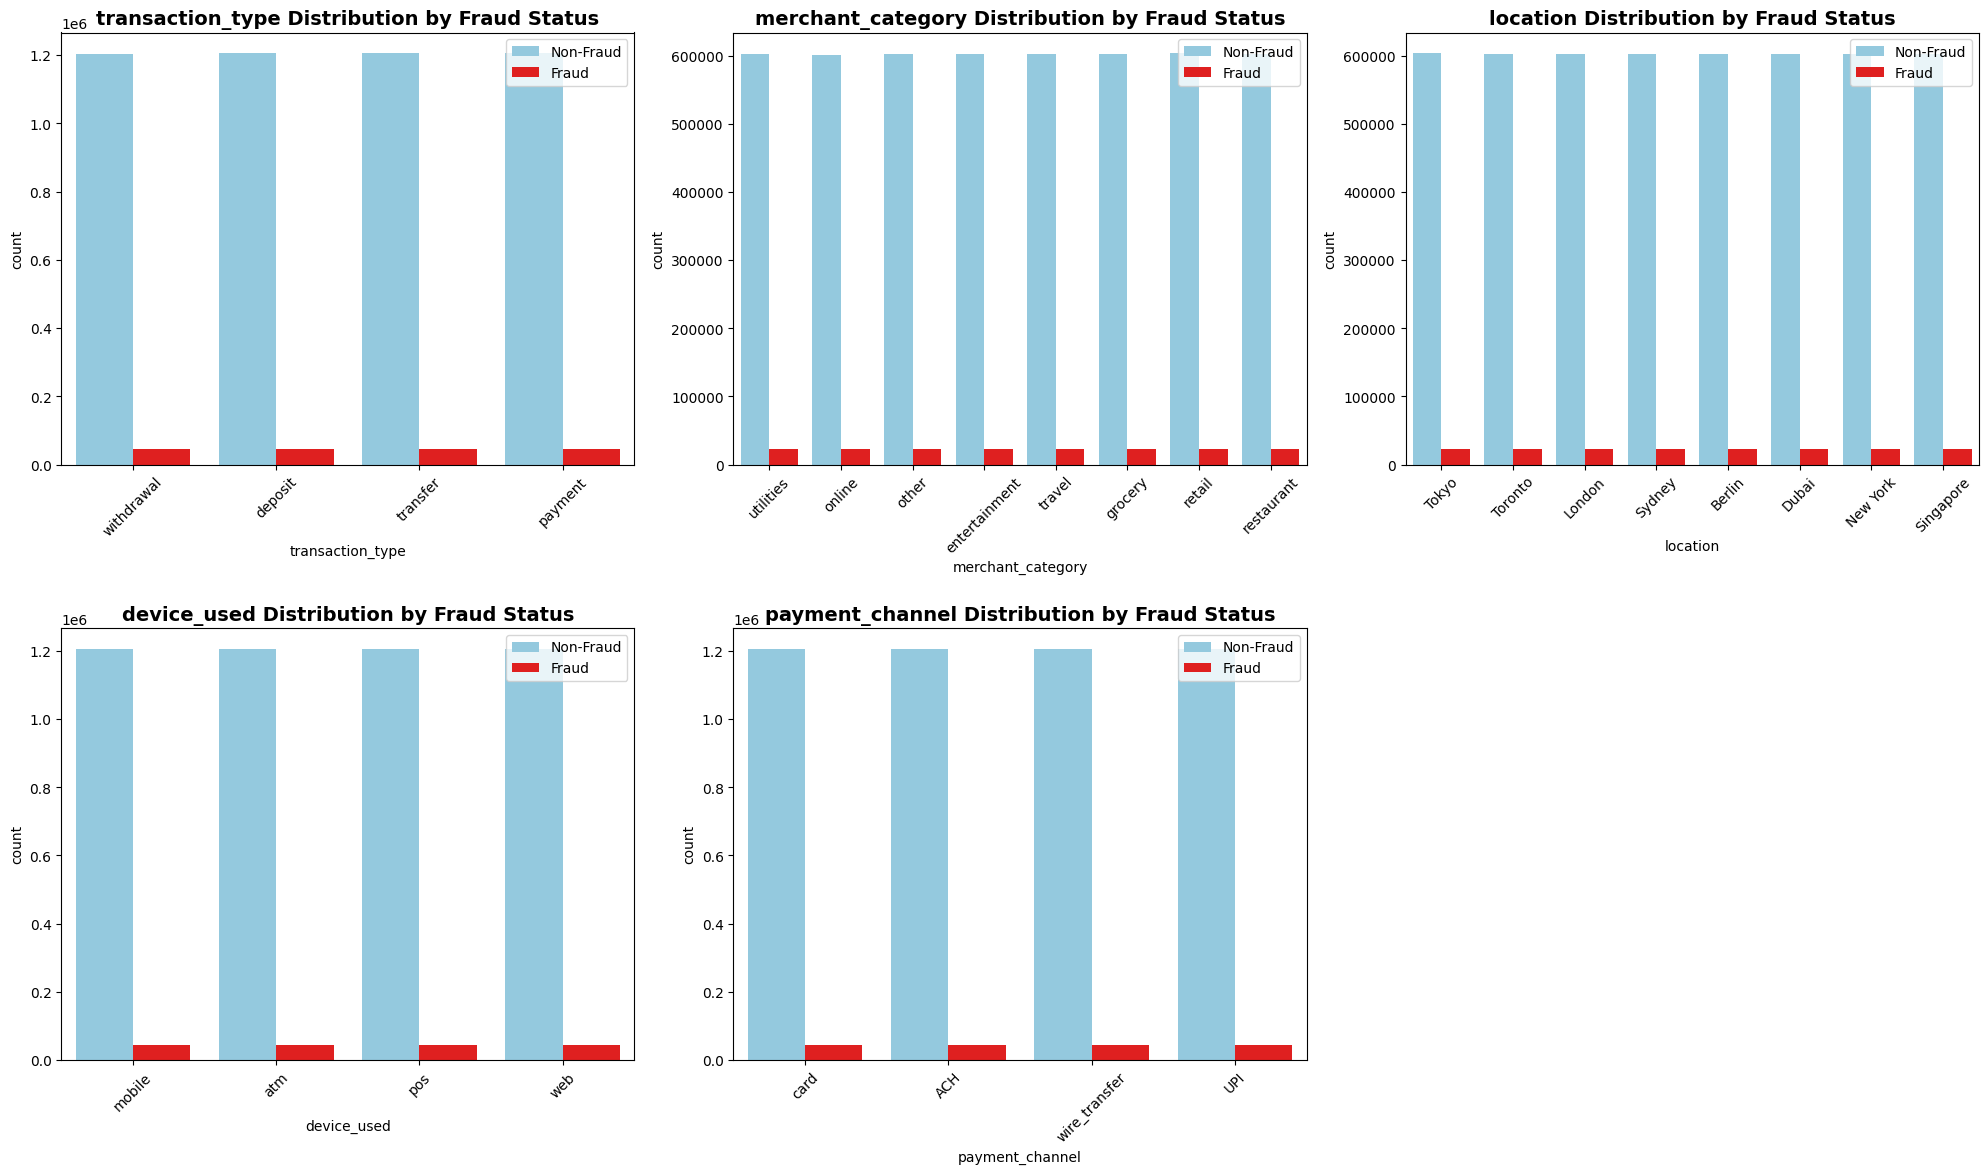

In [10]:
available_categorical_cols = ['transaction_type', 'merchant_category', 'location', 'device_used', 'payment_channel']

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()
    
for i, col in enumerate(available_categorical_cols):
    sns.countplot(data=df, x=col, hue='is_fraud', ax=axes[i], palette=['skyblue', 'red'])
    axes[i].set_title(f'{col} Distribution by Fraud Status', fontsize=14, fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(['Non-Fraud', 'Fraud'])

for j in range(len(available_categorical_cols), len(axes)):
    axes[j].set_visible(False)
    
plt.tight_layout()
plt.show()